# Understanding patch-clamp data

In the previous part of the tutorial

TODODO

In [ ]:
TODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODODTODODODODODODOD

additive: noise, leak, endogenous currents, estimating E, capacitative spikes


NEXT: DEALING WITH IT BY FILTERING / POST-PROCESSING / ONLINE-PROCESSING, OR BY ADDING TO NOISE MODEL AND FITTING (FINDING SIGMA)

THIS IS AN EXAMPLE OF WHAT WE DO LATER TOO!

In [3]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints

from library import ModelCVODESolver as Model

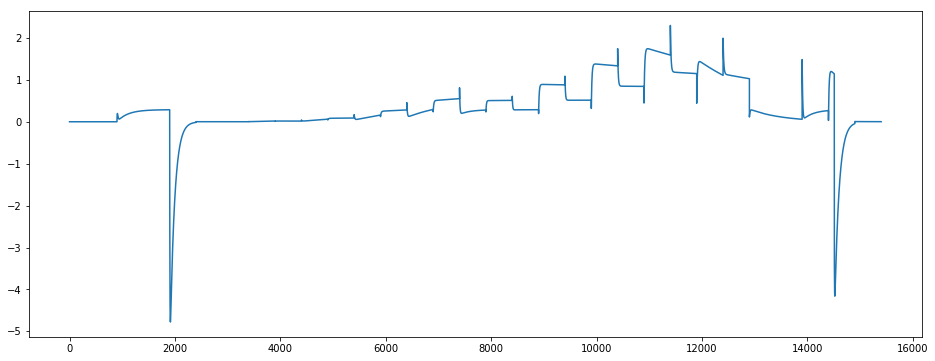

In [4]:
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model1 = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Evaluate the model
times = np.arange(0, 15400, 0.1)
values1 = model1.simulate(parameters, times)

plt.figure(figsize=(16, 6))
plt.plot(times, values1)
plt.show()

In [18]:
class ModelVoltageError(pints.ForwardModel):
    """A forward model that runs simulations with CVODE."""

    def __init__(self, protocol):

        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/full2-voltage-clamp-ikr-linleak.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]

        # Create a CVODE Simulation
        self.sim = myokit.Simulation(model, protocol)

        # Set the -80mV steady state as the default state
        #self.sim.set_default_state(hh_model.steady_state(-80))

    def n_parameters(self):
        return 9

    def simulate(self, parameters, times):

        # Reset to default time and state
        self.sim.reset()

        # Apply parameters
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        # Run
        tmax = times[-1] + (times[-1] - times[-2])
        try:
            log = self.sim.run(tmax, log_times=times, log=['voltageclamp.Iout'])
            return log['voltageclamp.Iout']
        except myokit.SimulationError:
            print('Error evaluating with parameters: ' + str(parameters))
            return np.nan * times


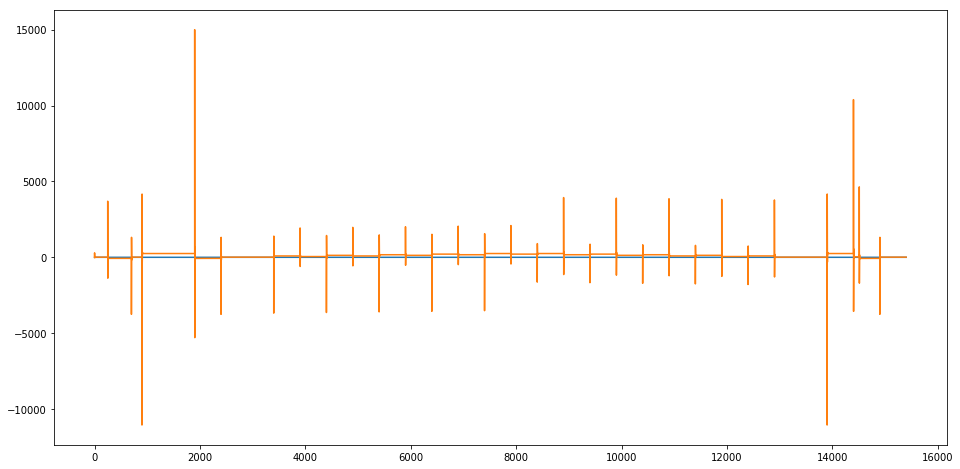

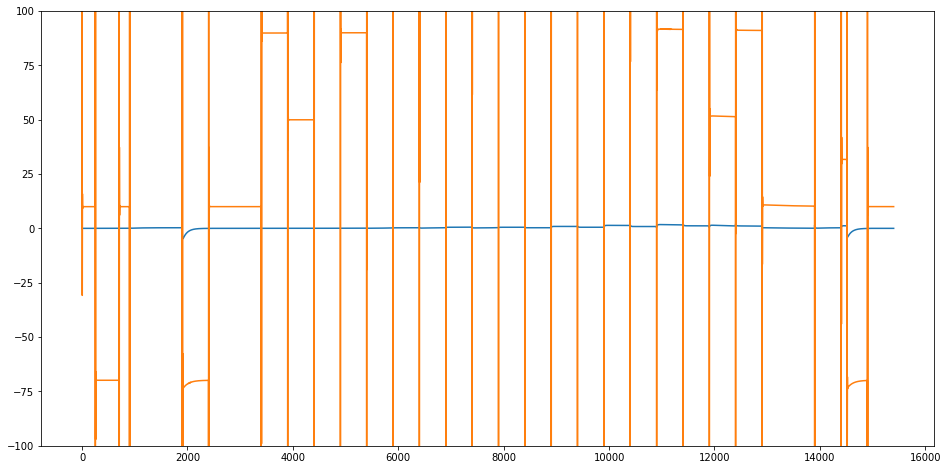

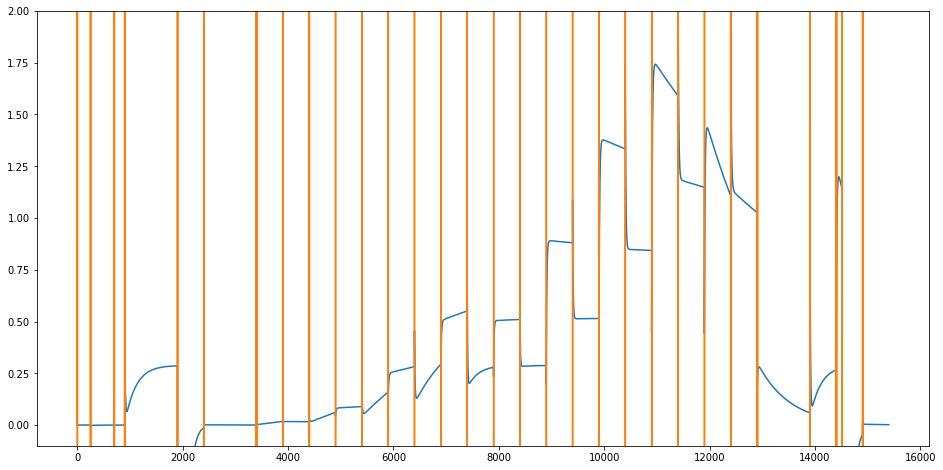

In [21]:
model2 = ModelVoltageError(protocol)

values2 = model2.simulate(parameters, times)

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)
plt.ylim(-100, 100)
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(times, values1)
plt.plot(times, values2)
plt.ylim(-0.1, 2)
plt.show()

## Capacitance filtering

Use a myokit.protocol to find the steps, cut a bit out

## Leak correction


We don't know best way


Explain use of ramps?

## Endogenous currents

(And maybe even gating current!)

Subtraction protocol!


## Reversal potential

Estimate from concentrations

Estimate from crossings? But hard if leaks aren't done right.
Use carefully placed ramps to avoid leak?

## Discrepancy

#### And what if the model's wrong?

Finally, we can ask what happens if we've simply got the electrophysiology model wrong.
In statistics, this has been called the _model discrepancy_, and some techniques have been suggested to perform parameter estimation even with a discrepancy (see [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0349)).
The bottom line though, is it's best to have the right model.

But what is the right model?
The answer, unfortunately, is not as "simple" as writing down equations for everything we can think of, as adding more detail to the model means adding more degrees of freedom and more parameters for inference, which reduces the model's identifiability.
Conversely, there are many details about the ionic current that our simple experiments won't reveal, so trying to fit a model that accounts for these details to this uninformative data increases the chance of overfitting, which reduces the quality of the model's predictions (see [Whittaker et al., 2020](https://doi.org/10.1002/wsbm.1482)).


## Summary
